# Exploring "HLSS30" using tensorlakehouse

### Data description
* Collection/dataset:"HLSS30"
* Data Source: GeoTiff stored on Cloud Object Store (COS) 

### Functionalities
* tensorlakehouse (openEO) functionalities:
    - describe collection
    - load collection

### Setup

1. Create a python virtualenv (python 3.11.7 is the recommended version). 
2. Clone the repository:
```
git clone https://github.com/IBM/tensorlakehouse-openeo-driver.git
``` 

3. Go to
```
cd tensorlakehouse-openeo-driver/tutorials
```

4. Install dependencies:
```
pip install -r tutorial_requirements.txt
```

5. Run jupyter notebook or jupyter lab
```
jupyter lab .
```


In [1]:
import rioxarray as rxr
import os
os.environ['USE_PYGEOS'] = '0'
import matplotlib.pyplot as plt
from pathlib import Path
# openeo is a client-side implementation that allows users to query OpenEO service
import openeo
# pystac_client is a client-side implementation that allows users to query STAC service
from pystac_client import Client
# OpenEO service URL
import os
from dotenv import load_dotenv
import pandas as pd
import xarray as xr
from shapely.geometry import shape
import geopandas
import geopandas
import folium
import time

Set URL and credentials of the OpenEO service

In [2]:
# username and password are hardcoded in the backend as an example for testing
load_dotenv()
OPENEO_URL = os.getenv("OPENEO_URL", "https://tensorlakehouse-openeo-driver-geospatial-be.apps.fmaas-backend.fmaas.res.ibm.com")
STAC_URL= os.getenv("STAC_URL","https://stac-fastapi-pgstac-geospatial-be.apps.fmaas-backend.fmaas.res.ibm.com")
OPENEO_USERNAME= os.environ["OPENEO_USERNAME"]
OPENEO_PASSWORD= os.environ["OPENEO_PASSWORD"]
catalog = Client.open(STAC_URL)

In [3]:
openeo_conn = openeo.connect(OPENEO_URL).authenticate_basic(OPENEO_USERNAME, OPENEO_PASSWORD)


### Setting input parameters: time range, area of interest, collection ID, filter

In [4]:
# set time interval

start ="2022-01-02T00:00:00Z"
# end = "2022-01-02T23:59:59Z"
end = "2022-02-02T00:00:00Z"
time_range = f"{start}/{end}"

# set bounding box
west = -121.30
east = -121.29
south = 44.10
north = 44.11

collection_id = "HLSS30"

# create data dir to save files
data_dir = Path("test_data")
if not data_dir.exists():
    data_dir.mkdir()

In [5]:


result = catalog.search(collections=[collection_id], bbox=[west, south, east, north], datetime=time_range)
counter = 0
ids = list()
geometry = list()
timestamp = list()
bands = list()

for item in result.items_as_dicts():
    ids.append(item["id"])
    geometry.append(shape(item["geometry"]))
    timestamp.append(pd.Timestamp(item["properties"]["datetime"]))
    bands.append(list(item["properties"]["cube:variables"].keys()))

gdf = geopandas.GeoDataFrame(data={"id": ids, "datetime": timestamp, "bands": bands}, geometry=geometry)
gdf



,id,datetime,bands,geometry
0,HLS.S30.T10TFP.2022032T190609.v2.0.Fmask,2022-02-01 19:12:14.831251+00:00,[Fmask],"POLYGON ((-121.74752 44.24655, -121.76797 43.2..."
1,HLS.S30.T10TFP.2022032T190609.v2.0.B8A,2022-02-01 19:12:14.831251+00:00,[B8A],"POLYGON ((-121.74752 44.24655, -121.76797 43.2..."
2,HLS.S30.T10TFP.2022032T190609.v2.0.B12,2022-02-01 19:12:14.831251+00:00,[B12],"POLYGON ((-121.74752 44.24655, -121.76797 43.2..."
3,HLS.S30.T10TFP.2022032T190609.v2.0.B11,2022-02-01 19:12:14.831251+00:00,[B11],"POLYGON ((-121.74752 44.24655, -121.76797 43.2..."
4,HLS.S30.T10TFP.2022032T190609.v2.0.B10,2022-02-01 19:12:14.831251+00:00,[B10],"POLYGON ((-121.74752 44.24655, -121.76797 43.2..."
...,...,...,...,...
149,HLS.S30.T10TFP.2022002T190759.v2.0.B05,2022-01-02 19:12:16.559745+00:00,[B05],"POLYGON ((-121.74752 44.24655, -121.76797 43.2..."
150,HLS.S30.T10TFP.2022002T190759.v2.0.B04,2022-01-02 19:12:16.559745+00:00,[B04],"POLYGON ((-121.74752 44.24655, -121.76797 43.2..."
151,HLS.S30.T10TFP.2022002T190759.v2.0.B03,2022-01-02 19:12:16.559745+00:00,[B03],"POLYGON ((-121.74752 44.24655, -121.76797 43.2..."
152,HLS.S30.T10TFP.2022002T190759.v2.0.B02,2022-01-02 19:12:16.559745+00:00,[B02],"POLYGON ((-121.74752 44.24655, -121.76797 43.2..."


In [6]:
minx, miny, maxx, maxy = gdf["geometry"].iloc[0].bounds

m = folium.Map(location=[(miny+maxy)/2, (minx+maxx)/2], zoom_start=6, control_scale=True)

# plot area of interest
aoi = {
      "type": "FeatureCollection",
      "features": [
        {
          "type": "Feature",
          "properties": {},
          "geometry": {
            "coordinates": [
              [
                [
                  west,
                  south
                ],
                [
                  west,
                  north
                ],
                [
                  east,
                  north
                ],
                [
                  east,
                  south
                ],
                [
                  west,
                  south
                ]
              ]
            ],
            "type": "Polygon"
          }
        }
      ]
    }

style_function = lambda x: {
    "color": "red",
    "fillColor": "red"
}
folium.GeoJson(aoi,
               style_function=style_function,
              ).add_to(m)

for geom in gdf["geometry"].unique():
    # selected_item = stac_df.iloc[i]
    # geom = selected_item["geometry"]
    lonmin, latmin, lonmax, latmax = geom.bounds
    # plot area of interest
    bbox = {
      "type": "FeatureCollection",
      "features": [
        {
          "type": "Feature",
          "properties": {},
          "geometry": {
            "coordinates": [
              [
                [
                  lonmin,
                  latmin
                ],
                [
                  lonmin,
                  latmax
                ],
                [
                  lonmax,
                  latmax
                ],
                [
                  lonmax,
                  latmin
                ],
                [
                  lonmin,
                  latmin
                ]
              ]
            ],
            "type": "Polygon"
          }
        }
      ]
    }


    folium.GeoJson(bbox,
                  # tooltip=folium.GeoJsonTooltip(fields=['FIELDNAME'])
                  ).add_to(m)
m

In [7]:
openeo_conn.describe_collection(collection_id)

{'cube:dimensions': {'bands': {'type': 'bands',
   'values': ['B01', 'B02', 'B03', 'B04', 'B8A', 'B11', 'B12', 'Fmask']},
  'time': {'extent': ['2020-01-01T00:00:00+00:00',
    '2022-01-01T00:00:00+00:00'],
   'type': 'temporal'},
  'x': {'axis': 'x', 'extent': [399960.0, 509760.0], 'type': 'spatial'},
  'y': {'axis': 'y', 'extent': [4300020.0, 4190220.0], 'type': 'spatial'}},
 'deprecated': False,
 'description': 'HLSS30',
 'extent': {'spatial': {'bbox': [[-180.0, -90.0, 180.0, 90.0]]},
  'temporal': {'interval': [['2020-01-01T00:00:00Z',
     '2022-01-01T00:00:00Z']]}},
 'id': 'HLSS30',
 'keywords': [],
 'license': 'Unknown',
 'links': [{'href': 'http://stac-fastapi-pgstac.geospatial-be.svc.cluster.local:8080/collections/HLSS30/items',
   'rel': 'items',
   'type': 'application/geo+json'},
  {'href': 'http://stac-fastapi-pgstac.geospatial-be.svc.cluster.local:8080/',
   'rel': 'parent',
   'type': 'application/json'},
  {'href': 'http://stac-fastapi-pgstac.geospatial-be.svc.cluster.local:8080/',
   'rel': 'root',
   'title': 'stac-fastapi',
   'type': 'application/json'},
  {'href': 'http://stac-fastapi-pgstac.geospatial-be.svc.cluster.local:8080/collections/HLSS30',
   'rel': 'self',
   'type': 'application/json'}],
 'providers': [{'description': 'Producers of awesome spatiotemporal assets',
   'name': 'IBM',
   'roles': ['producer', 'processor'],
   'url': 'https://www.ibm.com'}],
 'stac_extensions': [],
 'stac_version': '1.0.0',
 'summaries': {},
 'title': None,
 'type': 'Collection',
 'version': ''}

In [8]:
openeo_conn.list_processes()

[{'categories': ['cubes', 'import'],
  'description': 'Loads a file from a URL (supported protocols: HTTP and HTTPS).',
  'exceptions': {'FormatUnsuitable': {'message': "Data can't be loaded with the requested input format."}},
  'experimental': True,
  'id': 'load_url',
  'parameters': [{'description': 'The URL to read from. Authentication details such as API keys or tokens may need to be included in the URL.',
    'name': 'url',
    'schema': {'format': 'uri',
     'pattern': '^https?://',
     'subtype': 'uri',
     'title': 'URL',
     'type': 'string'}},
   {'description': 'The file format to use when loading the data. It must be one of the values that the server reports as supported input file formats, which usually correspond to the short GDAL/OGR codes. If the format is not suitable for loading the data, a `FormatUnsuitable` exception will be thrown. This parameter is *case insensitive*.',
    'name': 'format',
    'schema': {'subtype': 'input-format', 'type': 'string'}},
   {'default': {},
    'description': 'The file format parameters to use when reading the data. Must correspond to the parameters that the server reports as supported parameters for the chosen `format`. The parameter names and valid values usually correspond to the GDAL/OGR format options.',
    'name': 'options',
    'optional': True,
    'schema': {'subtype': 'input-format-options', 'type': 'object'}}],
  'returns': {'description': 'A data cube for further processing.',
   'schema': {'subtype': 'datacube', 'type': 'object'}},
  'summary': 'Load data from a URL'},
 {'categories': ['comparison'],
  'description': 'Checks whether the specified value `x` is valid. The following values are considered valid:\n\n* Any finite numerical value (integers and floating-point numbers). The definition of finite numbers follows the [IEEE Standard 754](https://ieeexplore.ieee.org/document/4610935) and excludes the special value `NaN` (not a number).\n* Any other value that is not a no-data value according to ``is_nodata()``. Thus all arrays, objects and strings are valid, regardless of their content.',
  'examples': [{'arguments': {'x': 1}, 'returns': True},
   {'arguments': {'x': 'Test'}, 'returns': True},
   {'arguments': {'x': None}, 'returns': False},
   {'arguments': {'x': [None, None]}, 'returns': True}],
  'id': 'is_valid',
  'links': [{'href': 'https://ieeexplore.ieee.org/document/4610935',
    'rel': 'about',
    'title': 'IEEE Standard 754-2008 for Floating-Point Arithmetic'}],
  'parameters': [{'description': 'The data to check.',
    'name': 'x',
    'schema': {'description': 'Any data type is allowed.'}}],
  'returns': {'description': '`true` if the data is valid, otherwise `false`.',
   'schema': {'type': 'boolean'}},
  'summary': 'Value is valid data'},
 {'categories': ['logic'],
  'description': 'Inverts a single boolean so that `true` gets `false` and `false` gets `true`.\n\nThe no-data value `null` is passed through and therefore gets propagated.',
  'examples': [{'arguments': {'x': None}, 'returns': None},
   {'arguments': {'x': False}, 'returns': True},
   {'arguments': {'x': True}, 'returns': False}],
  'id': 'not',
  'parameters': [{'description': 'Boolean value to invert.',
    'name': 'x',
    'schema': {'type': ['boolean', 'null']}}],
  'returns': {'description': 'Inverted boolean value.',
   'schema': {'type': ['boolean', 'null']}},
  'summary': 'Inverting a boolean'},
 {'categories': ['math > statistics'],
  'description': 'Calculates quantiles, which are cut points dividing the range of a sample distribution into either\n\n1. intervals corresponding to the given probabilities *or*\n2. equal-sized intervals (q-quantiles).\n\nEither the parameter `probabilities` or `q` must be specified, otherwise the `QuantilesParameterMissing` exception is thrown. If both parameters are set the `QuantilesParameterConflict` exception is thrown.\n\nSample quantiles can be computed with several different algorithms. Hyndman and Fan (1996) have concluded on n

## Loading tensorlakehouse datacube

In [9]:
bands = ["B02"]
spatial_extent={
        'west' : west,
        'south' : south,
        'east' : east,
        'north' : north
    }

temporal_extent = [start, end]

print(f"{collection_id=} {spatial_extent=} {temporal_extent=} {bands=}")
# note that 50 is a string because the data type of cloud_coverage is string
cube = openeo_conn.load_collection(
    collection_id=collection_id,
    spatial_extent=spatial_extent,
    temporal_extent=temporal_extent,
    bands=bands,
)
cube = cube.max_time()

collection_id='HLSS30' spatial_extent={'west': -121.3, 'south': 44.1, 'east': -121.29, 'north': 44.11} temporal_extent=['2022-01-02T00:00:00Z', '2022-02-02T00:00:00Z'] bands=['B02']


In [10]:
output_format = "netCDF"
cube = cube.save_result(output_format)

In [11]:
path = data_dir / f"test_{collection_id}.nc"
cube.download(path)
print(f"File has been downloaded: {path}")

Preflight process graph validation raised: [Internal] 'TensorLakehouseProcessRegistry' object has no attribute 'get_function'


File has been downloaded: test_data/test_HLSS30.nc


In [12]:
ds = xr.open_dataset(path)
ds

<xarray.Dataset>
Dimensions:      (y: 52, x: 48)
Coordinates:
  * y            (y) float64 5.742e+06 5.742e+06 ... 5.741e+06 5.741e+06
  * x            (x) float64 -2.712e+06 -2.712e+06 ... -2.711e+06 -2.711e+06
    spatial_ref  int32 ...
Data variables:
    B02          (y, x) float32 ...
Attributes:
    reduced_dimensions_min_values:  2022-01-02T19:12:16.559745

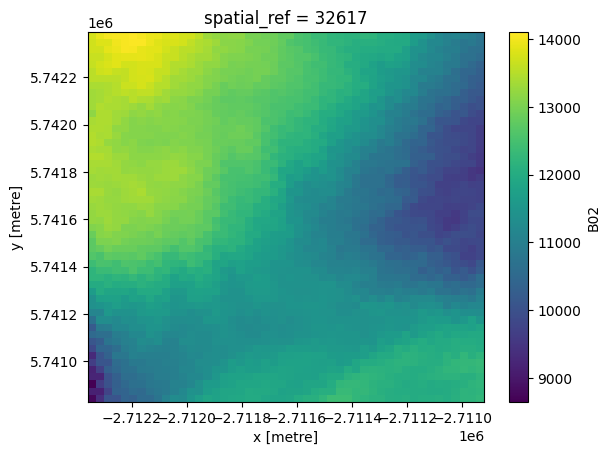

In [13]:
band = bands[0]
ds[band].plot()